# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience]()

### 0 - Setup

In [11]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install duckduckgo-search --> 6.2.12
#pip install wikipedia --> 1.4.0

In [12]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

{'model': 'llama3.1',
 'created_at': '2024-09-24T16:06:46.514884Z',
 'message': {'role': 'assistant',
  'content': "I don't have the ability to predict the future or access information that hasn't occurred yet. My training data only goes up until 2022, and I don't have any information about events that will occur in the future.\n\nAdditionally, it's not possible for me to know who died on a specific date without having access to real-time news or information. If you're looking for information about someone who passed away, I'd be happy to try to help you find out if they are public figures or were reported deceased by reputable sources."},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 36765920085,
 'load_duration': 8931512532,
 'prompt_eval_count': 22,
 'prompt_eval_duration': 5095165000,
 'eval_count': 109,
 'eval_duration': 22726607000}

### 1 - Tools

In [13]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser"""
    return DuckDuckGoSearchRun().run(q)

print( tool_browser(q) )

Alberto Fujimori (1938-2024) Sep 11 President of Peru (1990-2000), dies of cancer at 86 [1] Sep 11 Chad McQueen, American actor (Nightforce; The Karate Kid), dies at 63. Sep 14 Otis Davis, American athlete (Olympic gold 400m WR 44.9, 4x400m relay WR 3:02.2 1960), dies at 92. Sep 15 Gheorghe Mulțescu, Romanian soccer midfielder (16 caps; Jiul ... Rochester, Indiana. September 9, 2024 (79 years old) Vickey Karen Bryant. Atkins, Arkansas. September 9, 2024 (72 years old) Kathleen A. Jenkins. Yonkers, New York. September 9, 2024 (73 years old) Tommy Collins Jr. Actor James Earl Jones, known for his booming voice and many memorable performances, died Monday morning, according to his agent Barry McPherson. ... Mon September 9, 2024 Link Copied! September 9, 2024 1:33pm. James Earl Jones in 2015 WireImage. James Earl Jones, the revered actor who voiced Star Wars villain Darth Vader, starred in Field of Dreams and many other films and ... Updated 6:03 PM PDT, September 9, 2024. NEW YORK (AP) —

In [14]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

print( final_answer("yo") )

yo


In [15]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [16]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note in the memory.
Every time you find some information related to the user's question, you take note in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [17]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser
2. `final_answer`: Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.


In [18]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

{'created_at': '2024-09-24T16:07:32.499878Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 32,
 'eval_duration': 6423797000,
 'load_duration': 33051239,
 'message': {'content': '{"name":"final_answer", "parameters": {"text":"Hello! '
                        "I'm here to help with any questions or topics you'd "
                        'like to discuss."}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 303,
 'prompt_eval_duration': 36915235000,
 'total_duration': 43385560587}


In [19]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters": {"q":"death date September 9 2024"}}'

In [20]:
import json

tool_input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
tool_input

'death date September 9 2024'

In [21]:
# LLM with context
context = tool_browser(tool_input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

tool output:
 Marcellus Williams, the Missouri death row inmate who has maintained his innocence for nearly 24 years, is scheduled to be executed Tuesday, a day after the governor and the state Supreme Court ... September 9, 2024 (80 years old) Andrew Wayne Volkers. Sweet Home, Oregon. September 9, 2024 (43 years old) Donald D. Isgrigg. Rushville, Indiana. September 9, 2024 (71 years old) Lenore Jane Bartley. Rocky Hill, Connecticut. Alberto Fujimori (1938-2024) Sep 11 President of Peru (1990-2000), dies of cancer at 86 [1] Sep 11 Chad McQueen, American actor (Nightforce; The Karate Kid), dies at 63. Sep 14 Otis Davis, American athlete (Olympic gold 400m WR 44.9, 4x400m relay WR 3:02.2 1960), dies at 92. Sep 15 Gheorghe Mulțescu, Romanian soccer midfielder (16 caps; Jiul ... Marcellus Williams, 55, was convicted of first-degree murder in 2001 in the death of Felicia Gayle, a one-time newspaper reporter found stabbed to death in her home in 1998. His execution is set ... Sept. 23, 2024.

### 3 - Agent

##### Data Structure

In [22]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters": {"q":"death date September 9 2024"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'death date September 9 2024'}, tool_output=None)

In [23]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 deaths'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 26 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. September 9, 2024 4:30PM. Gold Derby. Throughout 2024, we will continue to update this IN MEMORIAM photo gallery with notable celebrity deaths from film, television, theater and music. Major ... Year of the Dragon. Year of the Snake. Year of the Horse. Year of the Goat/Sheep. Year of the Monkey. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths from Sep 9, 2024 

##### Memory System

In [24]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role":"assistant", "content":json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

save_memory(lst_res=[agent_res], user_q=q)

[]

In [25]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Run the Agent

In [26]:
def run_agent(prompt:str, dic_tools:dict, user_q:str, chat_history:list[dict], lst_res:list[AgentRes]) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "You must now use the `final_answer` tool."

    ## prompt tools
    str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])
    prompt_tools = f"You can use the following tools:\n{str_tools}"
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    #pprint(messages) #<--print to see prompt + tools + chat_history
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, dic_tools=dic_tools, user_q=q, chat_history=chat_history, lst_res=[])
print("\nagent_res:", agent_res)


agent_res: tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None


### 4 - Graph Workflow

##### State

In [27]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict

# test
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)],
 'output': {}}

##### Nodes

In [28]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_browser","final_answer"]},
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9, 2024 death news'} tool_output=None


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9, 2024 death news'}, tool_output=None)]}

In [29]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    print(state)
    res = state["lst_res"][-1]
    print(f"{res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
{'user_q': 'who died on September 9, 2024?', 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, {'role': 'assistant', 'content': "I'm good, thanks!"}, {'role': 'user', 'content': 'I have a question'}, {'role': 'assistant', 'content': 'tell me'}], 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)], 'output': {}}
tool_browser(input={'q': 'September 9 2024 deaths'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 26 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. Updated on September 22, 2024 08:29PM EDT. After saying sad and shocking goodbyes to the many stars who died in 2023, ... died at Aug. 9 at age 74. A cause of death was not immediately released ... Year of the Dragon. Year of the Snake. Year of the Horse. Year of the Goat/Sheep. Year of the Monkey. What happened on September 9, 2024. Browse historical events, famous birthdays and notable deaths f

##### Edges

In [30]:
def conditional_edges(state):
    print("--- conditional_edges ---")
    last_res = state["lst_res"][-1]
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"
    print("next_node:", next_node)
    return next_node #<--must return the next node to go

# test
conditional_edges(state)

--- conditional edges ---
next_node: tool_browser


'tool_browser'

##### Graph

In [31]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

## normal_edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

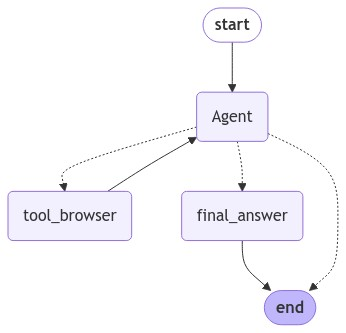

In [32]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [33]:
## input initial state
state = {'user_q':q,
         'chat_history':chat_history, 
         'lst_res':[], 
         'output':{} }

In [37]:
out = g.invoke(input=state)
agent_out = out['output'].tool_output

print("----")
agent_out

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None
--- conditional edges ---
next_node: tool_browser
--- node_tool ---
{'user_q': 'who died on September 9, 2024?', 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, {'role': 'assistant', 'content': "I'm good, thanks!"}, {'role': 'user', 'content': 'I have a question'}, {'role': 'assistant', 'content': 'tell me'}], 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)], 'output': {}}
tool_browser(input={'q': 'September 9 2024 deaths'})
--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'James Earl Jones death cause'} tool_output=None
--- conditional edges ---
next_node: tool_browser
--- node_tool ---
{'user_q': 'who died on September 9, 2024?', 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, {'role': 'assistant', 'content': "I'm good, thanks!"}, {'role': 'user', 'content': 'I

'James Earl Jones, the veteran actor best known for being the voice of Darth Vader in Star Wars, has died aged 93. He passed away at his home in New York on Monday morning, surrounded by his family.'

In [ ]:
steps = g.stream(input=state) 
for step in steps:
    print(step)
    print("----")

### 5 - Multiple Agents

##### Second Agent

In [38]:
agent_out

'James Earl Jones, the veteran actor best known for being the voice of Darth Vader in Star Wars, has died aged 93. He passed away at his home in New York on Monday morning, surrounded by his family.'

In [39]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool("tool_wikipedia")
def tool_wikipedia(q:str) -> str:
    """Search on Wikipedia"""
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run( q[:50] )

print( tool_wikipedia(agent_out) )

Page: Robert Earl Jones
Summary: Robert Earl Jones (February 3, 1910 – September 7, 2006), sometimes credited as Earl Jones, was an American actor. One of the first prominent black film stars, Jones was a living link with the Harlem Renaissance of the 1920s and 1930s, having worked with Langston Hughes early in his career.
Jones was best known for his leading roles in films such as Lying Lips (1939) and later in his career for supporting roles in films such as The Sting (1973), Sleepaway Camp, Trading Places (both 1983), The Cotton Club (1984), and Witness (1985). He was the father of actor James Earl Jones.

Page: Charles Gray (actor)
Summary: Charles Gray (born Donald Marshall Gray; 29 August 1928 – 7 March 2000) was an English actor and voice artist. Appearing in around 140 films and TV series, he was best known as the arch-villain Ernst Stavro Blofeld in the James Bond film Diamonds Are Forever; Dikko Henderson in a previous Bond film, You Only Live Twice; Sherlock Holmes's brother

In [40]:
dic_tools = {"tool_browser":tool_browser,
             "final_answer":final_answer,
             "tool_wikipedia":tool_wikipedia}

In [45]:
def node_agent_2(state):
    print("--- node_agent 2 ---")
    agent_res = run_agent(prompt=prompt, 
                          dic_tools={k:v for k,v in dic_tools.items() if k in ["tool_wikipedia","final_answer"]},
                          user_q=state["output"].tool_output, #<--changed user_q to the last output
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    print(agent_res)
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

##### Human in the Loop

In [42]:
# Node
def human_node(state):
    pass

# Conditional Edges
def human_edges(state):
    user_feedback = input("Should I continue? [Yes/No] --> ")
    if user_feedback.lower() in ["yes","y"]:
        return "Agent2"
    else:
        return END

# test
human_edges(state)

Should I continue? [Yes/No] -->  yes


'Agent2'

##### New Graph

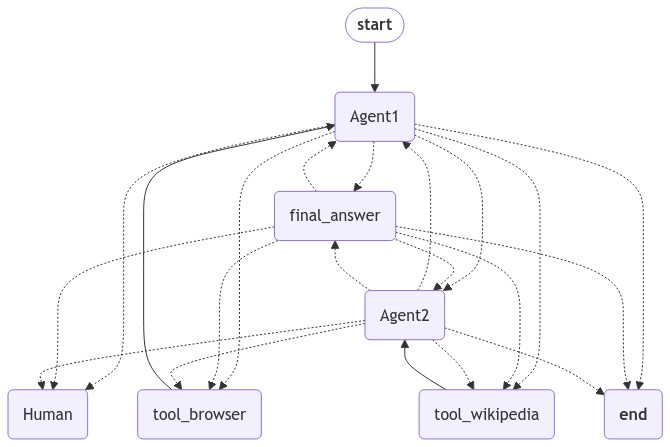

In [46]:
## start the graph
workflow = StateGraph(State)

########################## Agent 1 ##########################
## add Agent node
workflow.add_node(node="Agent1", action=node_agent) 
workflow.set_entry_point(key="Agent1") #<--user query

## add Tools nodes
workflow.add_node(node="tool_browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_browser", end_key="Agent1")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent1", path=conditional_edges)

########################## Human ##########################
## add Human node
workflow.add_node(node="Human", action=human_node)

## conditional_edges from Human
workflow.add_conditional_edges(source="final_answer", path=human_edges)

########################## Agent 2 ##########################
## add Agent node
workflow.add_node(node="Agent2", action=node_agent_2) 

## add Tools nodes
workflow.add_node(node="tool_wikipedia", action=node_tool)

## normal_edges to Agent
workflow.add_edge(start_key="tool_wikipedia", end_key="Agent2")

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent2", path=conditional_edges)

########################## End ##########################
## end the graph
g2 = workflow.compile()

## plot
display(Image(
    g2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [48]:
out_2 = g2.invoke(input=state)
agent_out_2 = out_2['output'].tool_output

print("----")
agent_out_2

--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'September 9 2024 deaths'} tool_output=None
--- conditional edges ---
next_node: tool_browser
--- node_tool ---
{'user_q': 'who died on September 9, 2024?', 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, {'role': 'assistant', 'content': "I'm good, thanks!"}, {'role': 'user', 'content': 'I have a question'}, {'role': 'assistant', 'content': 'tell me'}], 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)], 'output': {}}
tool_browser(input={'q': 'September 9 2024 deaths'})
--- node_agent ---
tool_name='tool_browser' tool_input={'q': 'James Earl Jones cause of death'} tool_output=None
--- conditional edges ---
next_node: tool_browser
--- node_tool ---
{'user_q': 'who died on September 9, 2024?', 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, {'role': 'assistant', 'content': "I'm good, thanks!"}, {'role': 'user', 'content':

Should I continue? [Yes/No] -->  yes


--- node_agent 2 ---
tool_name='final_answer' tool_input={'text': 'Actor James Earl Jones has died at the age of 93. He is known for his roles in Star Wars and The Lion King. Jones was a veteran actor with a long career, including work on Broadway and as a voice actor.'} tool_output=None
--- conditional edges ---
next_node: final_answer
--- node_tool ---
{'user_q': 'who died on September 9, 2024?', 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, {'role': 'assistant', 'content': "I'm good, thanks!"}, {'role': 'user', 'content': 'I have a question'}, {'role': 'assistant', 'content': 'tell me'}], 'lst_res': [AgentRes(tool_name='final_answer', tool_input={'text': 'Actor James Earl Jones has died at the age of 93. He is known for his roles in Star Wars and The Lion King. Jones was a veteran actor with a long career, including work on Broadway and as a voice actor.'}, tool_output=None)], 'output': AgentRes(tool_name='final_answer', tool_input={'text': 'James Earl Jone

Should I continue? [Yes/No] -->  yes


--- node_agent 2 ---
tool_name='final_answer' tool_input={'question': 'Actor James Earl Jones has died at the age of 93. He is known for his roles in Star Wars and The Lion King.', 'context': '', 'source': 'User Statement'} tool_output=None
--- conditional edges ---
next_node: final_answer
--- node_tool ---
{'user_q': 'who died on September 9, 2024?', 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, {'role': 'assistant', 'content': "I'm good, thanks!"}, {'role': 'user', 'content': 'I have a question'}, {'role': 'assistant', 'content': 'tell me'}], 'lst_res': [AgentRes(tool_name='final_answer', tool_input={'question': 'Actor James Earl Jones has died at the age of 93. He is known for his roles in Star Wars and The Lion King.', 'context': '', 'source': 'User Statement'}, tool_output=None)], 'output': AgentRes(tool_name='final_answer', tool_input={'text': 'Actor James Earl Jones has died at the age of 93. He is known for his roles in Star Wars and The Lion King. Jon

ValidationError: 1 validation error for final_answerSchema
text
  field required (type=value_error.missing)

In [ ]:
{'user_q': 'who died on September 9, 2024?', 
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, 
                  {'role': 'assistant', 'content': "I'm good, thanks!"}, 
                  {'role': 'user', 'content': 'I have a question'}, 
                  {'role': 'assistant', 'content': 'tell me'}], 
 'lst_res': [AgentRes(tool_name='tool_browser', 
                      tool_input={'q': 'September 9 2024 deaths'}, 
                      tool_output=None)], 
 'output': {}}

In [ ]:
{'user_q': 'who died on September 9, 2024?', 
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'}, 
                  {'role': 'assistant', 'content': "I'm good, thanks!"}, 
                  {'role': 'user', 'content': 'I have a question'}, 
                  {'role': 'assistant', 'content': 'tell me'}], 
 'lst_res': [AgentRes(tool_name='tool_wikipedia', 
                      tool_input={'search_query': 'September 9 2024 deaths'}, 
                      tool_output=None)], 
 'output': AgentRes(tool_name='final_answer', 
                    tool_input={'text': 'James Earl Jones, an American actor known for his iconic voice roles in Star Wars and The Lion King, passed away on September 9, 2024. He was 93 years old. Sources: Various online news articles, including one from the website Obituaries, which reported on his death. Additional information provided includes details about other notable individuals who died in September 2024.'}, 
                    tool_output='James Earl Jones, an American actor known for his iconic voice roles in Star Wars and The Lion King, passed away on September 9, 2024. He was 93 years old. Sources: Various online news articles, including one from the website Obituaries, which reported on his death. Additional information provided includes details about other notable individuals who died in September 2024.')}